## Setup

Load required packages

In [16]:
import pandas as pd
import io
import requests
import numpy as np
import random
import libpysal
import pysal
import pysal.lib
import gpytorch
import torch
import math
from sklearn import preprocessing

Create functions to save data

In [17]:
def picklecreator_ex1_train(dflist):
    for i, b in enumerate(dflist):
        dflist[b].to_pickle(r'./train_test_data/ex1/ex1_train_fold{:02d}.pkl'.format(i+1))
    return 1
def picklecreator_ex1_test(dflist):
    for i, b in enumerate(dflist):
        dflist[b].to_pickle(r'./train_test_data/ex1/ex1_test_fold{:02d}.pkl'.format(i+1))
    return 1

def picklecreator_ex2_train(dflist):
    for i, b in enumerate(dflist):
        dflist[b].to_pickle(r'./train_test_data/ex2/ex2_train_fold{:02d}.pkl'.format(i+1))
    return 1
def picklecreator_ex2_test(dflist):
    for i, b in enumerate(dflist):
        dflist[b].to_pickle(r'./train_test_data/ex2/ex2_test_fold{:02d}.pkl'.format(i+1))
    return 1

## Spatial Grid Expansion using `GPyTorch`

Define multi-output GP model for interpolating grid values

In [18]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)

        # SKI requires a grid size hyperparameter. This util can help with that
        grid_size = gpytorch.utils.grid.choose_grid_size(train_x)

        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=2
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.GridInterpolationKernel(
                gpytorch.kernels.RBFKernel(ard_num_dim=2,has_lengthscale=True), grid_size=grid_size, num_dims=2,
            ), num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

Define grid expansion function. This function takes in a regular point grid dataset `data` with coordinates `longitude` and `latitude` and features `y` and `z` and a factor `fact` by which to expand the grid.

The `MultitaskGPModel` defined above is then used to interpolate values `y` and `z` at the new, synthetic points in order to artificially inflate the training set.

In [23]:
def grid_expand_GP(data,fact):
    
    #Create lon and lat groups (for the case that the test data splits our regular box in two (geographically) separate training sets)
    lon_unique = data.longitude.unique() #Get unique lon/lat values
    inp = np.insert(np.diff(data.longitude.unique()),0,np.min(np.diff(data.longitude.unique()))) #Get differences at each step
    res = []
    k = 1
    for i in inp: #Loop over differences and assign new group if a gap is detected
        if i != np.min(inp):
            k = k+1
        else:
            k = k
        res += [k]

    d = {'longitude': lon_unique, 'group_lon': res} #Bind into a dataframe
    lon_group = pd.DataFrame(data=d)
    #Repeat for latitude
    lat_unique = data.latitude.unique()
    inp = np.insert(np.diff(data.latitude.unique()),0,np.min(np.diff(data.latitude.unique())))
    res = []
    k = 1
    for i in inp:
        if i != np.min(inp):
            k = k+1
        else:
            k = k
        res += [k]
    d = {'latitude': lat_unique, 'group_lat': res}
    lat_group = pd.DataFrame(data=d)
    #Merge with input data
    data = pd.merge(lon_group,data, how="right", on=["longitude"])
    data = pd.merge(lat_group,data, how="right", on=["latitude"])
    #Create dataset for storing the final results
    final_data = pd.DataFrame()
    
    for o in data.group_lat.unique():
        #Select group
        temp1_data = data[data["group_lat"]==o]
        for p in temp1_data.group_lon.unique():
            #Select group
            temp_data = temp1_data[temp1_data["group_lon"]==p]
            #Create new grid:
            #Copy column names from existing grid
            new_points = pd.DataFrame(columns=temp_data[["longitude","latitude"]].columns)
            #Expand longitude by factor `fact`
            dst = (temp_data[["longitude"]].max() - temp_data[["longitude"]].min()) / (len(temp_data.longitude.unique())-1)
            exp = float(dst/fact)
            x = []
            d = float(temp_data[["longitude"]].min())
            while d <= float(temp_data[["longitude"]].max()):
                x.append(d)    
                d = d + exp
            #Expand latitude by factor `fact`
            dst = (temp_data[["latitude"]].max() - temp_data[["latitude"]].min()) / (len(temp_data.latitude.unique())-1)
            exp = float(dst/fact)
            y = []
            d = float(temp_data[["latitude"]].min())
            while d <= float(temp_data[["latitude"]].max()):
                y.append(d)    
                d = d + exp
            #Bind new lat and lon values
            lon = x * len(y)
            lat = sorted(y*len(x))
            #Create new points dataframe
            new_points = pd.DataFrame({"longitude":lon,"latitude":lat})
            #Merge with existing dataframe
            new_data = pd.merge(new_points,data, how="left", on=["longitude","latitude"])
            #Create column to indicate whether observation is original or synthetic 
            new_data["synth"] = 0
            new_data.loc[new_data.id.isnull(), "synth"] = 1

            #Spatial operations:
            #Compute distance matrix of new grid
            dist = pysal.lib.cg.distance_matrix(np.array(new_data[["longitude","latitude"]]))
            #Extract and flatten 10 nearest distances
            k=10
            u_dist = np.unique(dist)
            k_min_dist = np.sort(u_dist.flatten())[:k]
            #Create KD tree
            kd = pysal.lib.cg.kdtree.KDTree(np.array(new_data[["longitude","latitude"]]))
            #Define neighbourhood (here Queen structure)
            w = pysal.lib.weights.distance.DistanceBand(kd, threshold=k_min_dist[2],binary=True,p=2) #Queen
            #Bind to existing data
            final_data = pd.concat([final_data, new_data])
        
    ###
    # GP INTERPOLATION (CAN BE COMMENTED OUT TO GET NA GRID)
    #Get train and test data
    train = final_data[final_data["synth"]==0]
    test = final_data[final_data["synth"]==1]
    #Convert to numpy
    train_x = np.asarray(train[["longitude","latitude"]])
    train_y = np.asarray(train[["y","z"]])
    test_x = np.asarray(test[["longitude","latitude"]])
    #Scale input and output
    scaler_train_y = preprocessing.StandardScaler().fit(train_y)
    train_y = scaler_train_y.transform(train_y)
    train_x = train_x / 100
    test_x = test_x / 100
    #Covert to pytorch tensor
    train_x = torch.from_numpy(train_x).float().cuda()
    train_y = torch.from_numpy(train_y).float().cuda()
    test_x = torch.from_numpy(test_x).float().cuda()
    #Train GP
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2).cuda()
    model = MultitaskGPModel(train_x, train_y, likelihood).cuda()
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()
    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    n_iter = 150
    for i in range(n_iter):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f' % (i + 1, n_iter, loss.item()))
        optimizer.step()
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
    model = MultitaskGPModel(train_x, train_y, likelihood).cuda()
    # Set into eval mode
    model.eval()
    likelihood.eval()
    # Make predictions
    with torch.no_grad(), gpytorch.fast_pred_var():
        observed_pred = likelihood(model(test_x))
        # Get mean
        mean = observed_pred.mean
        # Get lower and upper confidence bounds
        lower, upper = observed_pred.confidence_region()
    #Convert results back to GP
    temp = test_x.cpu().numpy()
    temp = temp * 100
    test[["longitude","latitude"]] = temp
    pred_y = mean.cpu().numpy()
    pred_y = scaler_train_y.inverse_transform(pred_y)
    test[["y","z"]] = pred_y     
    #Create final dataframe
    final_data = pd.concat([train, test])
    ### 
    
    #Re-assign IDs
    final_data[["id"]] = np.asarray(list(range(0,len(final_data["id"])))).reshape(-1,1)
    #Delete helper columns
    final_data = final_data.drop(columns=["group_lat","group_lon"])
    #Return new dataframe
    return final_data

### Grid Expansion: Synthetic data example 1

We first create lists of training and testing data for each of the 10 cross-validation folds (defined by lat / lon slicing)

In [24]:
#Read data
data = pd.read_csv("grid_aug_ex1.csv")
#Create train/test lists by fold
d_train = {}
d_test = {}
for name in data.filter(regex="fold").columns:
    d_train[name] = data[data[name]==2]
    d_train[name] = d_train[name][d_train[name].columns.drop(list(d_train[name].filter(regex='fold')))] 
    d_test[name] = data[data[name]==1]
    d_test[name] = d_test[name][d_test[name].columns.drop(list(d_test[name].filter(regex='fold')))] 

Create the new, synthetic training data using `grid_expand_GP`

In [25]:
for name, df in d_train.items():
    d_train[name] = grid_expand_GP(d_train[name],2)

Iter 1/150 - Loss: 377.450
Iter 2/150 - Loss: 367.568
Iter 3/150 - Loss: 359.047
Iter 4/150 - Loss: 352.360
Iter 5/150 - Loss: 345.088
Iter 6/150 - Loss: 337.945
Iter 7/150 - Loss: 331.513
Iter 8/150 - Loss: 327.655
Iter 9/150 - Loss: 323.908
Iter 10/150 - Loss: 319.609
Iter 11/150 - Loss: 312.526
Iter 12/150 - Loss: 307.294
Iter 13/150 - Loss: 302.562
Iter 14/150 - Loss: 294.652
Iter 15/150 - Loss: 288.057
Iter 16/150 - Loss: 283.271
Iter 17/150 - Loss: 279.001
Iter 18/150 - Loss: 272.287
Iter 19/150 - Loss: 265.592
Iter 20/150 - Loss: 257.634
Iter 21/150 - Loss: 252.383
Iter 22/150 - Loss: 245.342
Iter 23/150 - Loss: 237.244
Iter 24/150 - Loss: 231.661
Iter 25/150 - Loss: 225.182
Iter 26/150 - Loss: 216.857
Iter 27/150 - Loss: 210.311
Iter 28/150 - Loss: 203.980
Iter 29/150 - Loss: 196.691
Iter 30/150 - Loss: 190.980
Iter 31/150 - Loss: 182.834
Iter 32/150 - Loss: 175.763
Iter 33/150 - Loss: 168.942
Iter 34/150 - Loss: 163.452
Iter 35/150 - Loss: 155.439
Iter 36/150 - Loss: 147.621
I

C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

Iter 1/150 - Loss: 316.093
Iter 2/150 - Loss: 310.580
Iter 3/150 - Loss: 305.611
Iter 4/150 - Loss: 300.970
Iter 5/150 - Loss: 294.857
Iter 6/150 - Loss: 292.907
Iter 7/150 - Loss: 287.293
Iter 8/150 - Loss: 283.050
Iter 9/150 - Loss: 277.252
Iter 10/150 - Loss: 273.984
Iter 11/150 - Loss: 269.958
Iter 12/150 - Loss: 264.538
Iter 13/150 - Loss: 260.156
Iter 14/150 - Loss: 253.721
Iter 15/150 - Loss: 249.567
Iter 16/150 - Loss: 243.621
Iter 17/150 - Loss: 236.926
Iter 18/150 - Loss: 230.912
Iter 19/150 - Loss: 226.751
Iter 20/150 - Loss: 221.509
Iter 21/150 - Loss: 216.193
Iter 22/150 - Loss: 210.324
Iter 23/150 - Loss: 203.106
Iter 24/150 - Loss: 198.309
Iter 25/150 - Loss: 192.254
Iter 26/150 - Loss: 186.400
Iter 27/150 - Loss: 182.789
Iter 28/150 - Loss: 175.555
Iter 29/150 - Loss: 170.658
Iter 30/150 - Loss: 165.198
Iter 31/150 - Loss: 155.875
Iter 32/150 - Loss: 151.288
Iter 33/150 - Loss: 146.431
Iter 34/150 - Loss: 140.131
Iter 35/150 - Loss: 135.578
Iter 36/150 - Loss: 127.219
I

C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

Iter 1/150 - Loss: 320.027
Iter 2/150 - Loss: 313.980
Iter 3/150 - Loss: 306.797
Iter 4/150 - Loss: 300.692
Iter 5/150 - Loss: 296.529
Iter 6/150 - Loss: 292.150
Iter 7/150 - Loss: 287.678
Iter 8/150 - Loss: 284.283
Iter 9/150 - Loss: 278.342
Iter 10/150 - Loss: 273.857
Iter 11/150 - Loss: 267.869
Iter 12/150 - Loss: 263.902
Iter 13/150 - Loss: 257.437
Iter 14/150 - Loss: 252.606
Iter 15/150 - Loss: 246.757
Iter 16/150 - Loss: 242.805
Iter 17/150 - Loss: 234.970
Iter 18/150 - Loss: 230.264
Iter 19/150 - Loss: 225.112
Iter 20/150 - Loss: 219.311
Iter 21/150 - Loss: 213.156
Iter 22/150 - Loss: 209.291
Iter 23/150 - Loss: 203.388
Iter 24/150 - Loss: 198.243
Iter 25/150 - Loss: 191.016
Iter 26/150 - Loss: 186.447
Iter 27/150 - Loss: 180.221
Iter 28/150 - Loss: 175.559
Iter 29/150 - Loss: 168.223
Iter 30/150 - Loss: 162.324
Iter 31/150 - Loss: 157.958
Iter 32/150 - Loss: 152.320
Iter 33/150 - Loss: 146.253
Iter 34/150 - Loss: 138.671
Iter 35/150 - Loss: 134.663
Iter 36/150 - Loss: 129.285
I

C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

Iter 1/150 - Loss: 320.646
Iter 2/150 - Loss: 314.970
Iter 3/150 - Loss: 309.201
Iter 4/150 - Loss: 301.886
Iter 5/150 - Loss: 296.695
Iter 6/150 - Loss: 291.386
Iter 7/150 - Loss: 290.418
Iter 8/150 - Loss: 282.417
Iter 9/150 - Loss: 279.230
Iter 10/150 - Loss: 274.544
Iter 11/150 - Loss: 269.561
Iter 12/150 - Loss: 265.942
Iter 13/150 - Loss: 260.143
Iter 14/150 - Loss: 254.211
Iter 15/150 - Loss: 248.499
Iter 16/150 - Loss: 242.990
Iter 17/150 - Loss: 238.042
Iter 18/150 - Loss: 231.988
Iter 19/150 - Loss: 226.814
Iter 20/150 - Loss: 221.084
Iter 21/150 - Loss: 216.061
Iter 22/150 - Loss: 210.712
Iter 23/150 - Loss: 204.262
Iter 24/150 - Loss: 198.713
Iter 25/150 - Loss: 193.686
Iter 26/150 - Loss: 186.302
Iter 27/150 - Loss: 181.824
Iter 28/150 - Loss: 175.138
Iter 29/150 - Loss: 170.596
Iter 30/150 - Loss: 163.454
Iter 31/150 - Loss: 158.669
Iter 32/150 - Loss: 151.562
Iter 33/150 - Loss: 146.242
Iter 34/150 - Loss: 137.704
Iter 35/150 - Loss: 135.745
Iter 36/150 - Loss: 125.243
I

C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

Iter 1/150 - Loss: 377.065
Iter 2/150 - Loss: 367.712
Iter 3/150 - Loss: 358.912
Iter 4/150 - Loss: 352.314
Iter 5/150 - Loss: 345.900
Iter 6/150 - Loss: 339.613
Iter 7/150 - Loss: 334.071
Iter 8/150 - Loss: 330.525
Iter 9/150 - Loss: 324.109
Iter 10/150 - Loss: 319.882
Iter 11/150 - Loss: 317.138
Iter 12/150 - Loss: 308.452
Iter 13/150 - Loss: 303.585
Iter 14/150 - Loss: 298.038
Iter 15/150 - Loss: 291.694
Iter 16/150 - Loss: 283.923
Iter 17/150 - Loss: 277.305
Iter 18/150 - Loss: 269.933
Iter 19/150 - Loss: 263.314
Iter 20/150 - Loss: 257.225
Iter 21/150 - Loss: 249.058
Iter 22/150 - Loss: 244.383
Iter 23/150 - Loss: 237.705
Iter 24/150 - Loss: 229.652
Iter 25/150 - Loss: 223.366
Iter 26/150 - Loss: 218.431
Iter 27/150 - Loss: 211.509
Iter 28/150 - Loss: 202.303
Iter 29/150 - Loss: 197.060
Iter 30/150 - Loss: 190.097
Iter 31/150 - Loss: 181.567
Iter 32/150 - Loss: 175.405
Iter 33/150 - Loss: 168.851
Iter 34/150 - Loss: 161.684
Iter 35/150 - Loss: 154.823
Iter 36/150 - Loss: 147.402
I

C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

Iter 1/150 - Loss: 374.332
Iter 2/150 - Loss: 365.059
Iter 3/150 - Loss: 357.801
Iter 4/150 - Loss: 350.291
Iter 5/150 - Loss: 343.568
Iter 6/150 - Loss: 338.224
Iter 7/150 - Loss: 333.277
Iter 8/150 - Loss: 326.015
Iter 9/150 - Loss: 320.881
Iter 10/150 - Loss: 317.675
Iter 11/150 - Loss: 312.558
Iter 12/150 - Loss: 306.816
Iter 13/150 - Loss: 301.632
Iter 14/150 - Loss: 293.511
Iter 15/150 - Loss: 289.375
Iter 16/150 - Loss: 281.589
Iter 17/150 - Loss: 274.724
Iter 18/150 - Loss: 268.720
Iter 19/150 - Loss: 262.484
Iter 20/150 - Loss: 256.459
Iter 21/150 - Loss: 248.895
Iter 22/150 - Loss: 241.612
Iter 23/150 - Loss: 235.539
Iter 24/150 - Loss: 228.945
Iter 25/150 - Loss: 224.993
Iter 26/150 - Loss: 215.141
Iter 27/150 - Loss: 209.963
Iter 28/150 - Loss: 202.727
Iter 29/150 - Loss: 195.314
Iter 30/150 - Loss: 190.221
Iter 31/150 - Loss: 182.239
Iter 32/150 - Loss: 174.528
Iter 33/150 - Loss: 168.061
Iter 34/150 - Loss: 161.457
Iter 35/150 - Loss: 152.585
Iter 36/150 - Loss: 147.372
I

C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

Iter 1/150 - Loss: 323.100
Iter 2/150 - Loss: 317.284
Iter 3/150 - Loss: 310.610
Iter 4/150 - Loss: 304.587
Iter 5/150 - Loss: 300.051
Iter 6/150 - Loss: 293.606
Iter 7/150 - Loss: 289.797
Iter 8/150 - Loss: 285.885
Iter 9/150 - Loss: 282.278
Iter 10/150 - Loss: 275.709
Iter 11/150 - Loss: 271.281
Iter 12/150 - Loss: 267.310
Iter 13/150 - Loss: 261.451
Iter 14/150 - Loss: 256.517
Iter 15/150 - Loss: 250.465
Iter 16/150 - Loss: 245.225
Iter 17/150 - Loss: 238.336
Iter 18/150 - Loss: 232.781
Iter 19/150 - Loss: 227.563
Iter 20/150 - Loss: 223.252
Iter 21/150 - Loss: 216.016
Iter 22/150 - Loss: 211.597
Iter 23/150 - Loss: 204.214
Iter 24/150 - Loss: 199.883
Iter 25/150 - Loss: 193.371
Iter 26/150 - Loss: 188.635
Iter 27/150 - Loss: 182.376
Iter 28/150 - Loss: 177.893
Iter 29/150 - Loss: 171.731
Iter 30/150 - Loss: 165.288
Iter 31/150 - Loss: 160.096
Iter 32/150 - Loss: 152.700
Iter 33/150 - Loss: 147.743
Iter 34/150 - Loss: 139.973
Iter 35/150 - Loss: 136.304
Iter 36/150 - Loss: 131.348
I

C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

Iter 1/150 - Loss: 315.412
Iter 2/150 - Loss: 309.853
Iter 3/150 - Loss: 304.647
Iter 4/150 - Loss: 298.063
Iter 5/150 - Loss: 295.027
Iter 6/150 - Loss: 290.531
Iter 7/150 - Loss: 284.026
Iter 8/150 - Loss: 280.359
Iter 9/150 - Loss: 275.604
Iter 10/150 - Loss: 271.785
Iter 11/150 - Loss: 266.862
Iter 12/150 - Loss: 261.983
Iter 13/150 - Loss: 256.411
Iter 14/150 - Loss: 252.895
Iter 15/150 - Loss: 247.207
Iter 16/150 - Loss: 241.191
Iter 17/150 - Loss: 235.975
Iter 18/150 - Loss: 230.853
Iter 19/150 - Loss: 225.001
Iter 20/150 - Loss: 218.226
Iter 21/150 - Loss: 213.364
Iter 22/150 - Loss: 208.748
Iter 23/150 - Loss: 202.291
Iter 24/150 - Loss: 196.110
Iter 25/150 - Loss: 192.643
Iter 26/150 - Loss: 185.092
Iter 27/150 - Loss: 180.783
Iter 28/150 - Loss: 172.918
Iter 29/150 - Loss: 168.251
Iter 30/150 - Loss: 163.093
Iter 31/150 - Loss: 156.372
Iter 32/150 - Loss: 151.338
Iter 33/150 - Loss: 145.439
Iter 34/150 - Loss: 138.956
Iter 35/150 - Loss: 132.747
Iter 36/150 - Loss: 128.569
I

C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

Iter 1/150 - Loss: 315.083
Iter 2/150 - Loss: 309.891
Iter 3/150 - Loss: 304.371
Iter 4/150 - Loss: 298.694
Iter 5/150 - Loss: 294.735
Iter 6/150 - Loss: 290.034
Iter 7/150 - Loss: 285.961
Iter 8/150 - Loss: 280.819
Iter 9/150 - Loss: 276.720
Iter 10/150 - Loss: 271.661
Iter 11/150 - Loss: 267.328
Iter 12/150 - Loss: 262.988
Iter 13/150 - Loss: 259.290
Iter 14/150 - Loss: 253.621
Iter 15/150 - Loss: 247.914
Iter 16/150 - Loss: 241.402
Iter 17/150 - Loss: 237.802
Iter 18/150 - Loss: 232.433
Iter 19/150 - Loss: 226.488
Iter 20/150 - Loss: 219.880
Iter 21/150 - Loss: 214.995
Iter 22/150 - Loss: 208.919
Iter 23/150 - Loss: 203.115
Iter 24/150 - Loss: 198.694
Iter 25/150 - Loss: 192.831
Iter 26/150 - Loss: 187.321
Iter 27/150 - Loss: 182.872
Iter 28/150 - Loss: 175.481
Iter 29/150 - Loss: 168.976
Iter 30/150 - Loss: 164.200
Iter 31/150 - Loss: 159.233
Iter 32/150 - Loss: 152.980
Iter 33/150 - Loss: 145.590
Iter 34/150 - Loss: 139.992
Iter 35/150 - Loss: 134.983
Iter 36/150 - Loss: 127.044
I

C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

Iter 1/150 - Loss: 368.682
Iter 2/150 - Loss: 361.689
Iter 3/150 - Loss: 354.147
Iter 4/150 - Loss: 348.597
Iter 5/150 - Loss: 344.317
Iter 6/150 - Loss: 337.152
Iter 7/150 - Loss: 331.219
Iter 8/150 - Loss: 327.866
Iter 9/150 - Loss: 322.703
Iter 10/150 - Loss: 317.536
Iter 11/150 - Loss: 312.434
Iter 12/150 - Loss: 306.180
Iter 13/150 - Loss: 303.039
Iter 14/150 - Loss: 295.885
Iter 15/150 - Loss: 288.462
Iter 16/150 - Loss: 282.231
Iter 17/150 - Loss: 275.032
Iter 18/150 - Loss: 269.230
Iter 19/150 - Loss: 262.683
Iter 20/150 - Loss: 254.991
Iter 21/150 - Loss: 249.041
Iter 22/150 - Loss: 242.382
Iter 23/150 - Loss: 236.771
Iter 24/150 - Loss: 229.136
Iter 25/150 - Loss: 223.612
Iter 26/150 - Loss: 215.796
Iter 27/150 - Loss: 209.012
Iter 28/150 - Loss: 202.892
Iter 29/150 - Loss: 197.318
Iter 30/150 - Loss: 189.054
Iter 31/150 - Loss: 182.383
Iter 32/150 - Loss: 176.334
Iter 33/150 - Loss: 167.340
Iter 34/150 - Loss: 161.283
Iter 35/150 - Loss: 154.916
Iter 36/150 - Loss: 145.680
I

C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

Save train / test data for each fold as pickle file

In [26]:
picklecreator_ex1_train(d_train)
picklecreator_ex1_test(d_test)

1

### Grid Expansion: Synthetic data example 2

In [27]:
#Read data
data = pd.read_csv("grid_aug_ex2.csv")
#Create train/test lists by fold
d_train = {}
d_test = {}
for name in data.filter(regex="fold").columns:
    d_train[name] = data[data[name]==2]
    d_train[name] = d_train[name][d_train[name].columns.drop(list(d_train[name].filter(regex='fold')))] 
    d_test[name] = data[data[name]==1]
    d_test[name] = d_test[name][d_test[name].columns.drop(list(d_test[name].filter(regex='fold')))] 

In [28]:
for name, df in d_train.items():
    d_train[name] = grid_expand_GP(d_train[name],2)

Iter 1/150 - Loss: 889.056
Iter 2/150 - Loss: 883.280
Iter 3/150 - Loss: 878.071
Iter 4/150 - Loss: 874.475
Iter 5/150 - Loss: 871.648
Iter 6/150 - Loss: 871.469
Iter 7/150 - Loss: 872.454
Iter 8/150 - Loss: 873.745
Iter 9/150 - Loss: 873.085
Iter 10/150 - Loss: 872.530
Iter 11/150 - Loss: 871.216
Iter 12/150 - Loss: 871.117
Iter 13/150 - Loss: 869.634
Iter 14/150 - Loss: 869.183
Iter 15/150 - Loss: 868.523
Iter 16/150 - Loss: 868.997
Iter 17/150 - Loss: 868.621
Iter 18/150 - Loss: 869.005
Iter 19/150 - Loss: 868.568
Iter 20/150 - Loss: 868.666
Iter 21/150 - Loss: 868.737
Iter 22/150 - Loss: 868.800
Iter 23/150 - Loss: 868.516
Iter 24/150 - Loss: 867.522
Iter 25/150 - Loss: 867.625
Iter 26/150 - Loss: 867.096
Iter 27/150 - Loss: 867.242
Iter 28/150 - Loss: 867.576
Iter 29/150 - Loss: 867.354
Iter 30/150 - Loss: 867.472
Iter 31/150 - Loss: 868.161
Iter 32/150 - Loss: 867.774
Iter 33/150 - Loss: 867.443
Iter 34/150 - Loss: 866.716
Iter 35/150 - Loss: 867.125
Iter 36/150 - Loss: 866.521
I

C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

Iter 1/150 - Loss: 804.354
Iter 2/150 - Loss: 799.237
Iter 3/150 - Loss: 793.926
Iter 4/150 - Loss: 791.334
Iter 5/150 - Loss: 788.530
Iter 6/150 - Loss: 788.765
Iter 7/150 - Loss: 790.149
Iter 8/150 - Loss: 789.581
Iter 9/150 - Loss: 790.382
Iter 10/150 - Loss: 790.086
Iter 11/150 - Loss: 789.765
Iter 12/150 - Loss: 788.017
Iter 13/150 - Loss: 787.169
Iter 14/150 - Loss: 786.780
Iter 15/150 - Loss: 785.935
Iter 16/150 - Loss: 786.780
Iter 17/150 - Loss: 786.125
Iter 18/150 - Loss: 787.054
Iter 19/150 - Loss: 786.481
Iter 20/150 - Loss: 786.288
Iter 21/150 - Loss: 786.255
Iter 22/150 - Loss: 785.965
Iter 23/150 - Loss: 785.371
Iter 24/150 - Loss: 785.420
Iter 25/150 - Loss: 784.996
Iter 26/150 - Loss: 784.811
Iter 27/150 - Loss: 785.028
Iter 28/150 - Loss: 785.213
Iter 29/150 - Loss: 785.099
Iter 30/150 - Loss: 784.576
Iter 31/150 - Loss: 784.840
Iter 32/150 - Loss: 784.408
Iter 33/150 - Loss: 784.728
Iter 34/150 - Loss: 784.629
Iter 35/150 - Loss: 784.370
Iter 36/150 - Loss: 784.127
I

C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

Iter 1/150 - Loss: 848.724
Iter 2/150 - Loss: 841.609
Iter 3/150 - Loss: 837.239
Iter 4/150 - Loss: 833.502
Iter 5/150 - Loss: 831.583
Iter 6/150 - Loss: 831.810
Iter 7/150 - Loss: 830.893
Iter 8/150 - Loss: 832.105
Iter 9/150 - Loss: 831.965
Iter 10/150 - Loss: 831.817
Iter 11/150 - Loss: 831.287
Iter 12/150 - Loss: 829.169
Iter 13/150 - Loss: 828.104
Iter 14/150 - Loss: 827.902
Iter 15/150 - Loss: 826.986
Iter 16/150 - Loss: 827.703
Iter 17/150 - Loss: 827.590
Iter 18/150 - Loss: 828.161
Iter 19/150 - Loss: 827.522
Iter 20/150 - Loss: 827.035
Iter 21/150 - Loss: 827.308
Iter 22/150 - Loss: 827.075
Iter 23/150 - Loss: 827.165
Iter 24/150 - Loss: 826.747
Iter 25/150 - Loss: 826.972
Iter 26/150 - Loss: 826.018
Iter 27/150 - Loss: 825.773
Iter 28/150 - Loss: 826.303
Iter 29/150 - Loss: 825.902
Iter 30/150 - Loss: 825.792
Iter 31/150 - Loss: 826.348
Iter 32/150 - Loss: 826.420
Iter 33/150 - Loss: 826.115
Iter 34/150 - Loss: 825.739
Iter 35/150 - Loss: 826.115
Iter 36/150 - Loss: 826.089
I

C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

Iter 1/150 - Loss: 804.784
Iter 2/150 - Loss: 799.438
Iter 3/150 - Loss: 795.216
Iter 4/150 - Loss: 793.457
Iter 5/150 - Loss: 791.052
Iter 6/150 - Loss: 790.635
Iter 7/150 - Loss: 791.546
Iter 8/150 - Loss: 791.192
Iter 9/150 - Loss: 791.174
Iter 10/150 - Loss: 790.101
Iter 11/150 - Loss: 789.691
Iter 12/150 - Loss: 789.324
Iter 13/150 - Loss: 787.145
Iter 14/150 - Loss: 788.318
Iter 15/150 - Loss: 787.325
Iter 16/150 - Loss: 785.848
Iter 17/150 - Loss: 787.445
Iter 18/150 - Loss: 785.411
Iter 19/150 - Loss: 785.384
Iter 20/150 - Loss: 785.428
Iter 21/150 - Loss: 785.357
Iter 22/150 - Loss: 785.439
Iter 23/150 - Loss: 784.687
Iter 24/150 - Loss: 784.759
Iter 25/150 - Loss: 784.160
Iter 26/150 - Loss: 785.151
Iter 27/150 - Loss: 784.895
Iter 28/150 - Loss: 784.043
Iter 29/150 - Loss: 783.896
Iter 30/150 - Loss: 783.934
Iter 31/150 - Loss: 783.987
Iter 32/150 - Loss: 783.746
Iter 33/150 - Loss: 783.531
Iter 34/150 - Loss: 783.693
Iter 35/150 - Loss: 783.896
Iter 36/150 - Loss: 783.897
I

C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

Iter 1/150 - Loss: 887.157
Iter 2/150 - Loss: 880.445
Iter 3/150 - Loss: 875.911
Iter 4/150 - Loss: 872.663
Iter 5/150 - Loss: 869.840
Iter 6/150 - Loss: 869.346
Iter 7/150 - Loss: 869.912
Iter 8/150 - Loss: 870.659
Iter 9/150 - Loss: 870.991
Iter 10/150 - Loss: 871.474
Iter 11/150 - Loss: 870.447
Iter 12/150 - Loss: 869.472
Iter 13/150 - Loss: 868.926
Iter 14/150 - Loss: 868.023
Iter 15/150 - Loss: 867.353
Iter 16/150 - Loss: 867.920
Iter 17/150 - Loss: 867.425
Iter 18/150 - Loss: 867.564
Iter 19/150 - Loss: 867.625
Iter 20/150 - Loss: 868.019
Iter 21/150 - Loss: 867.496
Iter 22/150 - Loss: 867.409
Iter 23/150 - Loss: 867.177
Iter 24/150 - Loss: 867.239
Iter 25/150 - Loss: 866.451
Iter 26/150 - Loss: 866.624
Iter 27/150 - Loss: 866.126
Iter 28/150 - Loss: 866.401
Iter 29/150 - Loss: 866.402
Iter 30/150 - Loss: 866.346
Iter 31/150 - Loss: 866.988
Iter 32/150 - Loss: 866.314
Iter 33/150 - Loss: 866.406
Iter 34/150 - Loss: 866.458
Iter 35/150 - Loss: 866.550
Iter 36/150 - Loss: 865.774
I

C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

Iter 1/150 - Loss: 888.555
Iter 2/150 - Loss: 882.002
Iter 3/150 - Loss: 876.229
Iter 4/150 - Loss: 873.148
Iter 5/150 - Loss: 870.038
Iter 6/150 - Loss: 870.964
Iter 7/150 - Loss: 871.363
Iter 8/150 - Loss: 872.383
Iter 9/150 - Loss: 872.195
Iter 10/150 - Loss: 872.548
Iter 11/150 - Loss: 871.041
Iter 12/150 - Loss: 870.121
Iter 13/150 - Loss: 869.517
Iter 14/150 - Loss: 868.654
Iter 15/150 - Loss: 868.132
Iter 16/150 - Loss: 867.795
Iter 17/150 - Loss: 867.756
Iter 18/150 - Loss: 868.519
Iter 19/150 - Loss: 868.307
Iter 20/150 - Loss: 868.603
Iter 21/150 - Loss: 869.455
Iter 22/150 - Loss: 868.402
Iter 23/150 - Loss: 868.128
Iter 24/150 - Loss: 868.368
Iter 25/150 - Loss: 866.836
Iter 26/150 - Loss: 867.102
Iter 27/150 - Loss: 867.436
Iter 28/150 - Loss: 866.945
Iter 29/150 - Loss: 867.711
Iter 30/150 - Loss: 866.581
Iter 31/150 - Loss: 866.702
Iter 32/150 - Loss: 867.079
Iter 33/150 - Loss: 867.021
Iter 34/150 - Loss: 866.554
Iter 35/150 - Loss: 866.981
Iter 36/150 - Loss: 866.864
I

C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

Iter 1/150 - Loss: 804.113
Iter 2/150 - Loss: 799.869
Iter 3/150 - Loss: 795.406
Iter 4/150 - Loss: 793.582
Iter 5/150 - Loss: 788.268
Iter 6/150 - Loss: 789.200
Iter 7/150 - Loss: 788.929
Iter 8/150 - Loss: 790.630
Iter 9/150 - Loss: 790.525
Iter 10/150 - Loss: 789.276
Iter 11/150 - Loss: 788.168
Iter 12/150 - Loss: 788.246
Iter 13/150 - Loss: 787.301
Iter 14/150 - Loss: 786.279
Iter 15/150 - Loss: 785.520
Iter 16/150 - Loss: 785.843
Iter 17/150 - Loss: 786.333
Iter 18/150 - Loss: 786.773
Iter 19/150 - Loss: 786.665
Iter 20/150 - Loss: 786.209
Iter 21/150 - Loss: 785.721
Iter 22/150 - Loss: 785.384
Iter 23/150 - Loss: 786.205
Iter 24/150 - Loss: 785.382
Iter 25/150 - Loss: 784.846
Iter 26/150 - Loss: 784.894
Iter 27/150 - Loss: 784.314
Iter 28/150 - Loss: 784.046
Iter 29/150 - Loss: 784.351
Iter 30/150 - Loss: 784.098
Iter 31/150 - Loss: 784.506
Iter 32/150 - Loss: 784.290
Iter 33/150 - Loss: 784.654
Iter 34/150 - Loss: 784.170
Iter 35/150 - Loss: 784.166
Iter 36/150 - Loss: 783.956
I

C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

Iter 1/150 - Loss: 849.067
Iter 2/150 - Loss: 840.430
Iter 3/150 - Loss: 835.245
Iter 4/150 - Loss: 832.194
Iter 5/150 - Loss: 831.531
Iter 6/150 - Loss: 830.778
Iter 7/150 - Loss: 829.455
Iter 8/150 - Loss: 830.175
Iter 9/150 - Loss: 830.574
Iter 10/150 - Loss: 830.803
Iter 11/150 - Loss: 829.929
Iter 12/150 - Loss: 828.635
Iter 13/150 - Loss: 828.336
Iter 14/150 - Loss: 827.306
Iter 15/150 - Loss: 826.662
Iter 16/150 - Loss: 826.908
Iter 17/150 - Loss: 827.206
Iter 18/150 - Loss: 826.816
Iter 19/150 - Loss: 826.676
Iter 20/150 - Loss: 827.367
Iter 21/150 - Loss: 826.844
Iter 22/150 - Loss: 826.796
Iter 23/150 - Loss: 826.371
Iter 24/150 - Loss: 825.858
Iter 25/150 - Loss: 825.440
Iter 26/150 - Loss: 825.886
Iter 27/150 - Loss: 825.252
Iter 28/150 - Loss: 825.120
Iter 29/150 - Loss: 825.221
Iter 30/150 - Loss: 825.414
Iter 31/150 - Loss: 825.611
Iter 32/150 - Loss: 824.864
Iter 33/150 - Loss: 825.051
Iter 34/150 - Loss: 825.343
Iter 35/150 - Loss: 825.122
Iter 36/150 - Loss: 825.257
I

C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

Iter 1/150 - Loss: 806.906
Iter 2/150 - Loss: 799.634
Iter 3/150 - Loss: 796.726
Iter 4/150 - Loss: 792.973
Iter 5/150 - Loss: 790.682
Iter 6/150 - Loss: 789.630
Iter 7/150 - Loss: 790.857
Iter 8/150 - Loss: 790.108
Iter 9/150 - Loss: 791.268
Iter 10/150 - Loss: 790.693
Iter 11/150 - Loss: 789.248
Iter 12/150 - Loss: 789.437
Iter 13/150 - Loss: 787.116
Iter 14/150 - Loss: 787.298
Iter 15/150 - Loss: 786.621
Iter 16/150 - Loss: 786.795
Iter 17/150 - Loss: 785.919
Iter 18/150 - Loss: 786.302
Iter 19/150 - Loss: 786.679
Iter 20/150 - Loss: 786.762
Iter 21/150 - Loss: 785.841
Iter 22/150 - Loss: 785.569
Iter 23/150 - Loss: 785.135
Iter 24/150 - Loss: 785.183
Iter 25/150 - Loss: 784.651
Iter 26/150 - Loss: 785.026
Iter 27/150 - Loss: 784.831
Iter 28/150 - Loss: 784.174
Iter 29/150 - Loss: 784.226
Iter 30/150 - Loss: 784.568
Iter 31/150 - Loss: 784.555
Iter 32/150 - Loss: 784.042
Iter 33/150 - Loss: 784.263
Iter 34/150 - Loss: 784.374
Iter 35/150 - Loss: 784.257
Iter 36/150 - Loss: 784.244
I

C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

Iter 1/150 - Loss: 886.788
Iter 2/150 - Loss: 880.165
Iter 3/150 - Loss: 876.285
Iter 4/150 - Loss: 872.402
Iter 5/150 - Loss: 871.117
Iter 6/150 - Loss: 870.503
Iter 7/150 - Loss: 869.810
Iter 8/150 - Loss: 870.494
Iter 9/150 - Loss: 870.929
Iter 10/150 - Loss: 871.085
Iter 11/150 - Loss: 869.932
Iter 12/150 - Loss: 868.671
Iter 13/150 - Loss: 867.994
Iter 14/150 - Loss: 867.149
Iter 15/150 - Loss: 867.073
Iter 16/150 - Loss: 866.637
Iter 17/150 - Loss: 866.521
Iter 18/150 - Loss: 867.639
Iter 19/150 - Loss: 867.632
Iter 20/150 - Loss: 867.595
Iter 21/150 - Loss: 867.841
Iter 22/150 - Loss: 867.649
Iter 23/150 - Loss: 867.313
Iter 24/150 - Loss: 866.686
Iter 25/150 - Loss: 866.853
Iter 26/150 - Loss: 866.501
Iter 27/150 - Loss: 867.001
Iter 28/150 - Loss: 866.080
Iter 29/150 - Loss: 866.111
Iter 30/150 - Loss: 866.544
Iter 31/150 - Loss: 866.193
Iter 32/150 - Loss: 866.023
Iter 33/150 - Loss: 865.816
Iter 34/150 - Loss: 865.980
Iter 35/150 - Loss: 865.682
Iter 36/150 - Loss: 865.847
I

C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [29]:
picklecreator_ex2_train(d_train)
picklecreator_ex2_test(d_test)

1

### Plot some exampled for the expanded grid

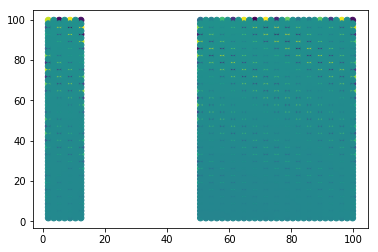

In [30]:
import matplotlib.pyplot as plt
plt.scatter(d_train["fold2"]["longitude"],d_train["fold2"]["latitude"],c=d_train["fold2"]["y"])

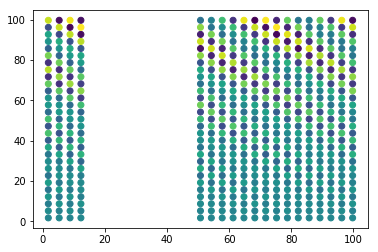

In [31]:
plt.scatter(data[data["fold2"]==2]["longitude"],data[data["fold2"]==2]["latitude"],c=data[data["fold2"]==2]["y"])